In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **Breast Cancer Data**

In [193]:
col_names = ['id_number', 'Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape','Marginal_Adhesion', 
            'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses', 'Class']
df = pd.read_csv('data/breast-cancer-wisconsin.data', header = None, names = col_names)
df = df.drop(columns = ['id_number'])
df.head()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


## **Data Cleaning**

In [56]:
df['Bare_Nuclei'].value_counts()

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Bare_Nuclei, dtype: int64

In [61]:
df['Bare_Nuclei'] = df['Bare_Nuclei'].replace('?', 1).astype('int64')

In [62]:
df.shape

(699, 10)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Clump_Thickness              699 non-null    int64
 1   Uniformity_of_Cell_Size      699 non-null    int64
 2   Uniformity_of_Cell_Shape     699 non-null    int64
 3   Marginal_Adhesion            699 non-null    int64
 4   Single_Epithelial_Cell_Size  699 non-null    int64
 5   Bare_Nuclei                  699 non-null    int64
 6   Bland_Chromatin              699 non-null    int64
 7   Normal_Nucleoli              699 non-null    int64
 8   Mitoses                      699 non-null    int64
 9   Class                        699 non-null    int64
dtypes: int64(10)
memory usage: 54.7 KB


## **Check the scale of attributes**

In [31]:
### is scaling relevant in Logistic Regression

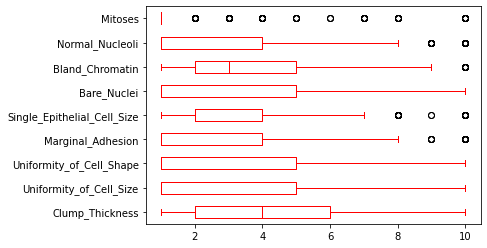

In [64]:
df.iloc[:, :-1].plot.box(vert = False, color = 'red');

## **Split the data into training and testing**

In [65]:
# using stratified fold
df['Class'].value_counts()/len(df['Class'])

2    0.655222
4    0.344778
Name: Class, dtype: float64

In [66]:
from sklearn.model_selection import StratifiedShuffleSplit
data = StratifiedShuffleSplit(n_splits = 1, test_size = 0.20, random_state = 21)

for train_index, test_index in data.split(df, df['Class']):
    train_set = df.loc[train_index]
    test_set  = df.loc[test_index] 

In [67]:
test_set['Class'].value_counts()/len(test_set['Class'])

2    0.657143
4    0.342857
Name: Class, dtype: float64

## **Implementing Logistic Regression**

In [153]:
from sklearn.linear_model import LogisticRegressionCV

X_train = train_set.iloc[:, :-1]
y_train = train_set.iloc[:, -1]


clf = LogisticRegressionCV(cv = 3, random_state = 21).fit(X_train, y_train)
clf.score(X_train, y_train)

0.9660107334525939

## **Confusion Matrix**

In [88]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(clf, X_train, y_train)

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_train, y_train_pred)
print(cf_matrix)

[[356  10]
 [ 12 181]]


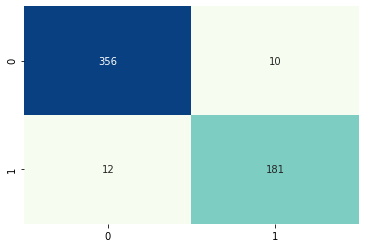

In [172]:
sns.heatmap(cf_matrix, annot = True, fmt = "d", cmap="GnBu", cbar = False);

## **Evaluation of Training Set**

In [155]:
X_test = test_set.iloc[:, :-1]
y_test = test_set.iloc[:, -1]

clf.score(X_test, y_test)

0.9785714285714285

In [165]:
y_test_pred = clf.predict(X_test)
cf_matrix_test = confusion_matrix(y_test, y_test_pred)
cf_matrix_test

array([[90,  2],
       [ 1, 47]])

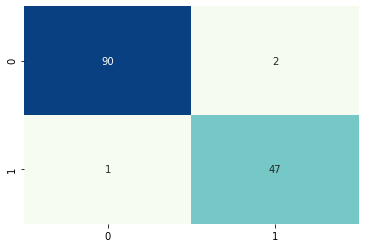

In [167]:
sns.heatmap(cf_matrix_test, annot = True, fmt = "d", cmap="GnBu", cbar = False);

## **Precision Vs Recall**

In [173]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder

y_scores = cross_val_predict(clf, X_train, y_train, method = "decision_function")
lben = LabelEncoder()
lben.fit(y_train)
ytrain = lben.transform(y_train)

precisions, recalls, thresholds = precision_recall_curve(ytrain, y_scores)

In [149]:
# recall at 99%
np.argmax(np.where(recalls[recalls> 0.99]))

17

In [151]:
print('Precision: ', precisions[17])
print('Recall: ', recalls[17])

Precision:  0.9320388349514563
Recall:  0.9948186528497409


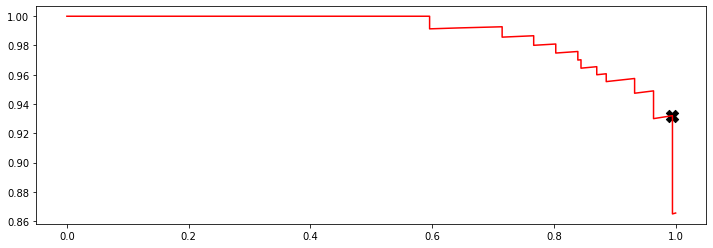

In [161]:
plt.figure(figsize = (12,4))
plt.scatter(recalls[17], precisions[17], c = 'black', s = 150, marker = 'X')
plt.plot(recalls, precisions, 'r-');

## **Prediction using a threshold value**

In [190]:
def predict_cancer(attrb, threshold):
    y_score = clf.decision_function([attrb])
    y_predict = y_score > threshold
    return y_predict

In [195]:
# threshold value for 99% recall
threshold = thresholds[17]
predict_cancer(X_test.iloc[8], threshold)

array([ True])